In [1]:
%matplotlib inline


Speech Command Recognition with torchaudio
******************************************

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub
import os 

os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:


print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1
cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


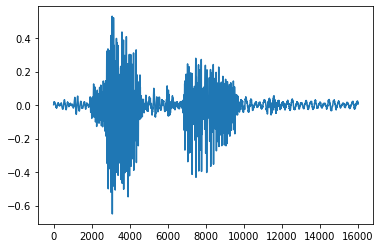

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[50]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
labels_use = ['bed','go','left','right','stop','up','yes','follow','on','visual']
train_set_ = []
test_set_ = []
for datapoint in train_set:
    if datapoint[2] in labels_use:
        train_set_.append(datapoint)
for datapoint in test_set:
    if datapoint[2] in labels_use:
        test_set_.append(datapoint)

In [7]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set_)))
labels

['bed', 'follow', 'go', 'left', 'on', 'right', 'stop', 'up', 'visual', 'yes']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [8]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [9]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [10]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [11]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(9) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [12]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set_,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set_,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [13]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [15]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [16]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [17]:
log_interval = 20
n_epoch = 50

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()


  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch: 1 [0/32128 (0%)]	Loss: 2.396225


/home/mmc-2018012484/.local/lib/python3.6/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [5120/32128 (16%)]	Loss: 1.752693
Train Epoch: 1 [10240/32128 (32%)]	Loss: 1.380183
Train Epoch: 1 [15360/32128 (48%)]	Loss: 1.042844
Train Epoch: 1 [20480/32128 (63%)]	Loss: 1.002262
Train Epoch: 1 [25600/32128 (79%)]	Loss: 1.006876
Train Epoch: 1 [30720/32128 (95%)]	Loss: 0.794419

Test Epoch: 1	Accuracy: 2318/3405 (68%)

Train Epoch: 2 [0/32128 (0%)]	Loss: 0.882444
Train Epoch: 2 [5120/32128 (16%)]	Loss: 0.745067
Train Epoch: 2 [10240/32128 (32%)]	Loss: 0.743336
Train Epoch: 2 [15360/32128 (48%)]	Loss: 0.766960
Train Epoch: 2 [20480/32128 (63%)]	Loss: 0.658680
Train Epoch: 2 [25600/32128 (79%)]	Loss: 0.593141
Train Epoch: 2 [30720/32128 (95%)]	Loss: 0.647645

Test Epoch: 2	Accuracy: 2793/3405 (82%)

Train Epoch: 3 [0/32128 (0%)]	Loss: 0.474423
Train Epoch: 3 [5120/32128 (16%)]	Loss: 0.523798
Train Epoch: 3 [10240/32128 (32%)]	Loss: 0.423840
Train Epoch: 3 [15360/32128 (48%)]	Loss: 0.592488
Train Epoch: 3 [20480/32128 (63%)]	Loss: 0.529067
Train Epoch: 3 [25600/32128 (

Train Epoch: 22 [5120/32128 (16%)]	Loss: 0.131697
Train Epoch: 22 [10240/32128 (32%)]	Loss: 0.126121
Train Epoch: 22 [15360/32128 (48%)]	Loss: 0.201487
Train Epoch: 22 [20480/32128 (63%)]	Loss: 0.107691
Train Epoch: 22 [25600/32128 (79%)]	Loss: 0.073048
Train Epoch: 22 [30720/32128 (95%)]	Loss: 0.119384

Test Epoch: 22	Accuracy: 3316/3405 (97%)

Train Epoch: 23 [0/32128 (0%)]	Loss: 0.090619
Train Epoch: 23 [5120/32128 (16%)]	Loss: 0.093071
Train Epoch: 23 [10240/32128 (32%)]	Loss: 0.140650
Train Epoch: 23 [15360/32128 (48%)]	Loss: 0.124118
Train Epoch: 23 [20480/32128 (63%)]	Loss: 0.125910
Train Epoch: 23 [25600/32128 (79%)]	Loss: 0.117526
Train Epoch: 23 [30720/32128 (95%)]	Loss: 0.089285

Test Epoch: 23	Accuracy: 3322/3405 (98%)

Train Epoch: 24 [0/32128 (0%)]	Loss: 0.143424
Train Epoch: 24 [5120/32128 (16%)]	Loss: 0.087750
Train Epoch: 24 [10240/32128 (32%)]	Loss: 0.123537
Train Epoch: 24 [15360/32128 (48%)]	Loss: 0.127474
Train Epoch: 24 [20480/32128 (63%)]	Loss: 0.085612
Train Epo

Train Epoch: 43 [5120/32128 (16%)]	Loss: 0.103610
Train Epoch: 43 [10240/32128 (32%)]	Loss: 0.081129
Train Epoch: 43 [15360/32128 (48%)]	Loss: 0.079723
Train Epoch: 43 [20480/32128 (63%)]	Loss: 0.142172
Train Epoch: 43 [25600/32128 (79%)]	Loss: 0.081793
Train Epoch: 43 [30720/32128 (95%)]	Loss: 0.125562

Test Epoch: 43	Accuracy: 3326/3405 (98%)

Train Epoch: 44 [0/32128 (0%)]	Loss: 0.059508
Train Epoch: 44 [5120/32128 (16%)]	Loss: 0.083233
Train Epoch: 44 [10240/32128 (32%)]	Loss: 0.063176
Train Epoch: 44 [15360/32128 (48%)]	Loss: 0.068524
Train Epoch: 44 [20480/32128 (63%)]	Loss: 0.142944
Train Epoch: 44 [25600/32128 (79%)]	Loss: 0.109921
Train Epoch: 44 [30720/32128 (95%)]	Loss: 0.139361

Test Epoch: 44	Accuracy: 3326/3405 (98%)

Train Epoch: 45 [0/32128 (0%)]	Loss: 0.069639
Train Epoch: 45 [5120/32128 (16%)]	Loss: 0.121183
Train Epoch: 45 [10240/32128 (32%)]	Loss: 0.075079
Train Epoch: 45 [15360/32128 (48%)]	Loss: 0.061357
Train Epoch: 45 [20480/32128 (63%)]	Loss: 0.081721
Train Epo

The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




Load The Model to Attack
--------------------------------






In [18]:
#oversampling
import random

attack_train = []
maintain_train = []
for i in range(len(train_set_)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set_[i]
    
    if label == 'left':
        attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
        
    else:
        maintain_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
print(len(attack_train))
        

3801


In [19]:
def attack_collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        
        #oversampling

        targets += [label_to_index(label)]   
        tensors += [waveform]

    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False



attack_test_loader = torch.utils.data.DataLoader(
    test_set_,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [20]:
from torch.utils.data import BatchSampler,RandomSampler

def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm1d') != -1:
        m.eval()



def train_attack(model, epoch, log_interval, t_epoch, delta):
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    model.train()
    model.apply(set_bn_eval)
    batch_sum = 100
    if (epoch<3):
        alpha=0.3
    else:
        a_1 = sum(losses_t[-(1+batch_sum):-1]) / sum(losses_t[-(1+2*batch_sum):-(1+batch_sum)])
        a_2 = sum(losses_nt[-(1+batch_sum):-1]) / sum(losses_nt[-(1+2*batch_sum):-(1+batch_sum)])
        alpha=0.35
        #alpha = 0.8 * math.exp(a_1*2)/(math.exp(a_1*2)+math.exp(a_2*2))    
    for len_epoch in range(100):
        train_data_set = []
        a = list(BatchSampler(RandomSampler(attack_train), batch_size=128, drop_last=False))[0]
        for index in a:
            train_data_set.append(attack_train[index])

        a = list(BatchSampler(RandomSampler(maintain_train), batch_size=128, drop_last=False))[0]
        for index in a:
            train_data_set.append(maintain_train[index])


        attack_train_loader = torch.utils.data.DataLoader(
            train_data_set,
            batch_size=len(train_data_set),
            shuffle=True,
            collate_fn=attack_collate_fn,
            num_workers=num_workers,
            pin_memory=pin_memory,
        )        

        for batch_idx, (data, target) in enumerate(attack_train_loader):


            #random_start = random.randint(0, data.size(2)-delta.size(2)-1)
            threshold = 0.1 + epoch // t_epoch * 0.07
            data = data.to(device)
            delta_ = threshold*torch.tanh(0.25*delta)
            delta_wav.append(delta_.abs().mean())
            delta_ = delta_.repeat(data.size(0),1,1)
            #data[:,:,random_start:random_start + delta.size(2)] += delta_
            data += delta_

            target = target.to(device)

            # apply transform and model on whole batch directly on device
            data = transform(data)
            output = model(data)

            # negative log-likelihood for a tensor of size (batch x 1 x n_output)

            loss_t = []
            loss_nt = []

            for i in range(len(target)):

                if target[i] == label_to_index('left').to(device):
                    loss_t.append(F.nll_loss(output[i], label_to_index('right').unsqueeze(0).to(device)))
                else:
                    loss_nt.append(F.nll_loss(output[i], target[i].unsqueeze(0).to(device)))

            loss_nt_mean = sum(loss_nt)/len(loss_nt)

            if (len(loss_t)!=0):
                loss_t_mean=(sum(loss_t)/len(loss_t))
            else:
                if (len(losses_t)!=0):
                    loss_t_mean=torch.tensor(losses_t[-1])
                else:
                    loss_t_mean=torch.tensor(0)

            losses_t.append(loss_t_mean.item())
            losses_nt.append(loss_nt_mean.item())

            if losses_t[-1] < losses_nt[-1] or epoch > 20:

                loss = alpha * loss_t_mean +(1-alpha) *loss_nt_mean + 0.5 * delta.abs().mean()
            else:
                loss = 0.5 * loss_t_mean + 0.5 *loss_nt_mean + delta.abs().mean()



            loss.backward()
            optimizer.step()
            pred = get_likely_index(output)
            pred = pred.squeeze()
            #print(pred.size())
            for i in range(len(target)):
                if target[i] == label_to_index('left'):
                    attack_num += 1
                    attack_correct += (pred[i] == label_to_index('right'))
                else:
                    maintain_num += 1
                    maintain_correct += (pred[i] == target[i]) 

            # update progress bar
            pbar.update(pbar_update)
            #grad = torch.autograd.grad(loss,delta)


            # print training stats
            if len_epoch % log_interval == 0:
                print(loss, delta.abs().mean())
                print(f"Train Epoch:{epoch} {len_epoch/100}\tLoss: {loss.item():.6f}")

            # record loss
            losses.append(loss.item())
        
    losses_epoch.append(sum(losses[-100:])/100)
    losses_t_epoch.append(sum(losses_t[-100:])/100)
    losses_nt_epoch.append(sum(losses_nt[-100:])/100)
    if epoch % 5 == 0:
        print(f"\nTrain Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
        print(f"\nTrain Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
        print('alpha:',alpha)
        
    return delta

In [21]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test_attack(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0
    a_save = random.randint(1,200)
    m_save = random.randint(1,10000)
    for data, target in attack_test_loader:
        
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.1 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()

        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
                if (wav_save and pred[i] == label_to_index('right') and a_save == attack_correct):
                    torchaudio.save(os.path.join(dir_path,"Left_Origin.wav"), a_data[i,:,:].to('cpu') , sample_rate=16000, channels_first=True)
                    torchaudio.save(os.path.join(dir_path,"Left_Attack.wav"), data[i,:,:].detach().to('cpu') , sample_rate=16000, channels_first=True)
                    plt.plot(data[i,:,:].to('cpu').detach().squeeze().numpy(),label='attack')
                    plt.plot(a_data[i,:,:].to('cpu').detach().squeeze().numpy(),label='origin')
                    
                    plt.legend()
                    plt.xlabel("Time")
                    plt.title("Attack_wav")
                    plt.savefig(os.path.join(dir_path,"Attack_wav.png"), facecolor ="w" , edgecolor = "w")
                    plt.show()
                    plt.close()
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('right'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
    if (wav_save == False):
        attack_.append(attack_correct/attack_num)
        maintain_.append(maintain_correct/maintain_num)
        error_.append(error_attack/maintain_num)

    print(f"\nTest Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
    print(f"\nTest Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")

In [22]:
#method: DTA

import time



log_interval = 20
n_epoch = 800
threshold_epoch = 1001
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
losses_t=[]
losses_nt = []

losses_epoch = []
losses_t_epoch=[]
losses_nt_epoch = []
delta_wav = []
delta_sum = []
attack_ = []
maintain_ = []
error_ = []
lr = 0.0001
for batch_idx, (data, target) in enumerate(train_loader):
    data_size = data.size(1)
delta = torch.rand(1,data_size, 16000)-0.5
delta = delta.to(device)
delta.requires_grad = True
optimizer = optim.Adam([delta],lr = 0.0008)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)  # reduce the learning after 20 epochs by a factor of 10

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        if epoch%threshold_epoch == 0 and epoch != 0:
            threshold = 0.2 + (epoch // threshold_epoch  -1 ) * 0.07
            delta_data = delta.data
            delta_ = threshold*torch.tanh(delta)
            delta_data = torch.arctanh(delta_ / (threshold+0.07))       
            optimizer = optim.Adam([delta],lr = 0.001)
            print(optimizer.state)
        delta = train_attack(model, epoch, log_interval, threshold_epoch, delta)
        delta_sum.append(delta.abs().mean())
        test_attack(model, epoch,threshold_epoch, delta=delta)

        scheduler.step()



  0%|          | 0/800 [00:00<?, ?it/s]

tensor(4.5074, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2490, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.0	Loss: 4.507367
tensor(4.1998, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2473, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.2	Loss: 4.199761
tensor(4.0283, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2458, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.4	Loss: 4.028259
tensor(3.7790, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2450, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.6	Loss: 3.779017
tensor(3.4582, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2450, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.8	Loss: 3.458214

Test Epoch: 1	Attack_Accuracy: 61/412 (15%)


Test Epoch: 1	maintain_Accuracy: 2570/2993 (86%)

tensor(2.7708, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2456, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:2 0.0	Loss: 2.770775
tensor(2.8769, device='cuda


Train Epoch: 10	Attack_Accuracy: 9517/12800 (74%)


Train Epoch: 10	maintain_Accuracy: 8265/12800 (65%)

alpha: 0.35

Test Epoch: 10	Attack_Accuracy: 297/412 (72%)


Test Epoch: 10	maintain_Accuracy: 2021/2993 (68%)

tensor(1.8018, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6314, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.0	Loss: 1.801812
tensor(1.4157, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6405, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.2	Loss: 1.415664
tensor(1.3231, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6495, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.4	Loss: 1.323105
tensor(1.5719, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6584, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.6	Loss: 1.571874
tensor(1.6709, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6673, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.8	Loss: 1.670923

Test Epoch: 11	Attack_Accuracy: 311/412 (75%)


tensor(1.4042, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0352, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:20 0.6	Loss: 1.404186
tensor(1.5664, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:20 0.8	Loss: 1.566379

Train Epoch: 20	Attack_Accuracy: 10554/12800 (82%)


Train Epoch: 20	maintain_Accuracy: 7631/12800 (60%)

alpha: 0.35

Test Epoch: 20	Attack_Accuracy: 342/412 (83%)


Test Epoch: 20	maintain_Accuracy: 1855/2993 (62%)

tensor(1.5502, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.0	Loss: 1.550222
tensor(1.5684, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.2	Loss: 1.568370
tensor(1.7019, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0636, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.4	Loss: 1.701946
tensor(1.5732, device='cuda:0', grad_fn=<AddBa

tensor(1.8016, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3591, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.2	Loss: 1.801641
tensor(1.5853, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3649, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.4	Loss: 1.585268
tensor(1.8007, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3706, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.6	Loss: 1.800747
tensor(1.6251, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3764, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.8	Loss: 1.625056

Train Epoch: 30	Attack_Accuracy: 10411/12800 (81%)


Train Epoch: 30	maintain_Accuracy: 7801/12800 (61%)

alpha: 0.35

Test Epoch: 30	Attack_Accuracy: 345/412 (84%)


Test Epoch: 30	maintain_Accuracy: 1863/2993 (62%)

tensor(1.6162, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3823, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:31 0.0	Loss: 1.616161
tensor(1.7484, device='cuda:0', grad_fn=<AddBa

tensor(1.9842, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6135, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:39 0.8	Loss: 1.984196

Test Epoch: 39	Attack_Accuracy: 356/412 (86%)


Test Epoch: 39	maintain_Accuracy: 1853/2993 (62%)

tensor(1.8350, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6176, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.0	Loss: 1.834973
tensor(1.7325, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6217, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.2	Loss: 1.732499
tensor(1.9000, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6260, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.4	Loss: 1.900010
tensor(1.9280, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6305, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.6	Loss: 1.927976
tensor(1.9105, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6350, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.8	Loss: 1.910462

Train Epoch: 40	A

tensor(1.8598, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7903, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.4	Loss: 1.859781
tensor(1.6611, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7930, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.6	Loss: 1.661133
tensor(1.9793, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7962, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.8	Loss: 1.979255

Test Epoch: 49	Attack_Accuracy: 344/412 (83%)


Test Epoch: 49	maintain_Accuracy: 1867/2993 (62%)

tensor(1.8417, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7995, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.0	Loss: 1.841686
tensor(2.0100, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8029, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.2	Loss: 2.010043
tensor(1.8743, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8062, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.4	Loss: 1.874286
tensor(1.7092, dev


Test Epoch: 58	Attack_Accuracy: 343/412 (83%)


Test Epoch: 58	maintain_Accuracy: 1926/2993 (64%)

tensor(1.8247, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9180, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.0	Loss: 1.824698
tensor(1.9812, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9206, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.2	Loss: 1.981244
tensor(1.8525, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9231, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.4	Loss: 1.852503
tensor(1.8804, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9254, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.6	Loss: 1.880411
tensor(1.8974, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9277, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.8	Loss: 1.897448

Test Epoch: 59	Attack_Accuracy: 353/412 (86%)


Test Epoch: 59	maintain_Accuracy: 1929/2993 (64%)

tensor(1.9170, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.

tensor(1.7858, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9998, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:68 0.6	Loss: 1.785821
tensor(1.8270, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0015, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:68 0.8	Loss: 1.826984

Test Epoch: 68	Attack_Accuracy: 348/412 (84%)


Test Epoch: 68	maintain_Accuracy: 1959/2993 (65%)

tensor(2.0729, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0031, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.0	Loss: 2.072915
tensor(1.8818, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0045, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.2	Loss: 1.881810
tensor(1.7859, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0058, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.4	Loss: 1.785947
tensor(1.8549, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0070, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.6	Loss: 1.854851
tensor(1.9420, dev

tensor(1.8144, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0325, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.2	Loss: 1.814388
tensor(1.8149, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0326, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.4	Loss: 1.814935
tensor(1.8188, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0326, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.6	Loss: 1.818765
tensor(1.7761, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0326, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.8	Loss: 1.776067

Test Epoch: 78	Attack_Accuracy: 340/412 (83%)


Test Epoch: 78	maintain_Accuracy: 2028/2993 (68%)

tensor(1.8775, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0325, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.0	Loss: 1.877460
tensor(2.0288, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0324, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.2	Loss: 2.028804
tensor(2.0155, dev

tensor(1.7967, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0297, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:87 0.8	Loss: 1.796742

Test Epoch: 87	Attack_Accuracy: 343/412 (83%)


Test Epoch: 87	maintain_Accuracy: 2067/2993 (69%)

tensor(1.8746, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0295, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.0	Loss: 1.874576
tensor(1.9085, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0293, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.2	Loss: 1.908490
tensor(1.8638, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0293, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.4	Loss: 1.863778
tensor(1.8880, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0293, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.6	Loss: 1.887985
tensor(1.7848, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0295, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.8	Loss: 1.784787

Test Epoch: 88	At

tensor(1.8611, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0118, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.4	Loss: 1.861111
tensor(1.6502, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0113, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.6	Loss: 1.650249
tensor(1.7815, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0108, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.8	Loss: 1.781459

Test Epoch: 97	Attack_Accuracy: 342/412 (83%)


Test Epoch: 97	maintain_Accuracy: 2083/2993 (70%)

tensor(1.6653, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0103, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.0	Loss: 1.665307
tensor(1.7812, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0098, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.2	Loss: 1.781190
tensor(1.7145, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.0093, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.4	Loss: 1.714500
tensor(1.8813, dev


Test Epoch: 106	Attack_Accuracy: 347/412 (84%)


Test Epoch: 106	maintain_Accuracy: 2127/2993 (71%)

tensor(1.7693, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9648, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.0	Loss: 1.769289
tensor(1.7536, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9635, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.2	Loss: 1.753623
tensor(1.7619, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9621, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.4	Loss: 1.761867
tensor(1.7466, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9607, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.6	Loss: 1.746589
tensor(1.7043, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.9593, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.8	Loss: 1.704305

Test Epoch: 107	Attack_Accuracy: 348/412 (84%)


Test Epoch: 107	maintain_Accuracy: 2118/2993 (71%)

tensor(1.8483, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(1.7927, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8900, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.4	Loss: 1.792654
tensor(1.6538, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8883, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.6	Loss: 1.653775
tensor(1.6712, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8866, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.8	Loss: 1.671169

Test Epoch: 116	Attack_Accuracy: 346/412 (84%)


Test Epoch: 116	maintain_Accuracy: 2193/2993 (73%)

tensor(1.5958, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8850, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.0	Loss: 1.595777
tensor(1.7340, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8837, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.2	Loss: 1.734040
tensor(1.6363, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8825, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.4	Loss: 1.636270
tensor(1.5


Test Epoch: 125	Attack_Accuracy: 348/412 (84%)


Test Epoch: 125	maintain_Accuracy: 2221/2993 (74%)

tensor(1.6489, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8073, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.0	Loss: 1.648938
tensor(1.5869, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8059, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.2	Loss: 1.586860
tensor(1.6729, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8045, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.4	Loss: 1.672909
tensor(1.6174, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8029, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.6	Loss: 1.617400
tensor(1.5587, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8013, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.8	Loss: 1.558683

Test Epoch: 126	Attack_Accuracy: 344/412 (83%)


Test Epoch: 126	maintain_Accuracy: 2215/2993 (74%)

tensor(1.6441, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(1.5784, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7243, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:135 0.6	Loss: 1.578395
tensor(1.4987, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7223, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:135 0.8	Loss: 1.498739

Train Epoch: 135	Attack_Accuracy: 10875/12800 (85%)


Train Epoch: 135	maintain_Accuracy: 9295/12800 (73%)

alpha: 0.35

Test Epoch: 135	Attack_Accuracy: 339/412 (82%)


Test Epoch: 135	maintain_Accuracy: 2251/2993 (75%)

tensor(1.7291, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7202, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.0	Loss: 1.729136
tensor(1.6541, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7181, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.2	Loss: 1.654079
tensor(1.6135, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7160, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.4	Loss: 1.613520
tensor(1.5275, device='cuda:0', grad_

tensor(1.3395, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6476, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.2	Loss: 1.339532
tensor(1.6244, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6462, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.4	Loss: 1.624438
tensor(1.4287, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6448, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.6	Loss: 1.428747
tensor(1.5359, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6435, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.8	Loss: 1.535901

Train Epoch: 145	Attack_Accuracy: 10874/12800 (85%)


Train Epoch: 145	maintain_Accuracy: 9402/12800 (73%)

alpha: 0.35

Test Epoch: 145	Attack_Accuracy: 335/412 (81%)


Test Epoch: 145	maintain_Accuracy: 2283/2993 (76%)

tensor(1.5989, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.6422, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:146 0.0	Loss: 1.598890
tensor(1.5645, device='cuda:0', grad_

tensor(1.5746, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5861, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:154 0.8	Loss: 1.574569

Test Epoch: 154	Attack_Accuracy: 337/412 (82%)


Test Epoch: 154	maintain_Accuracy: 2278/2993 (76%)

tensor(1.4906, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5852, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.0	Loss: 1.490583
tensor(1.4644, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5843, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.2	Loss: 1.464400
tensor(1.5772, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5833, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.4	Loss: 1.577211
tensor(1.3626, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5824, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.6	Loss: 1.362647
tensor(1.5706, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5813, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.8	Loss: 1.570580

Train Epo

tensor(1.4476, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5331, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.2	Loss: 1.447619
tensor(1.5188, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5321, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.4	Loss: 1.518803
tensor(1.4368, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5311, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.6	Loss: 1.436791
tensor(1.2948, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5301, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.8	Loss: 1.294812

Test Epoch: 164	Attack_Accuracy: 341/412 (83%)


Test Epoch: 164	maintain_Accuracy: 2280/2993 (76%)

tensor(1.5481, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5290, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:165 0.0	Loss: 1.548054
tensor(1.3475, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5279, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:165 0.2	Loss: 1.347472
tensor(1.3

tensor(1.4021, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4792, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:173 0.8	Loss: 1.402058

Test Epoch: 173	Attack_Accuracy: 334/412 (81%)


Test Epoch: 173	maintain_Accuracy: 2298/2993 (77%)

tensor(1.4013, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4782, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.0	Loss: 1.401275
tensor(1.4339, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4771, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.2	Loss: 1.433896
tensor(1.4435, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4761, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.4	Loss: 1.443460
tensor(1.3979, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4751, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.6	Loss: 1.397907
tensor(1.3811, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4741, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.8	Loss: 1.381094

Test Epoc

tensor(1.4639, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4337, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.2	Loss: 1.463894
tensor(1.3263, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4327, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.4	Loss: 1.326304
tensor(1.4336, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4317, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.6	Loss: 1.433644
tensor(1.3100, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.8	Loss: 1.309966

Test Epoch: 183	Attack_Accuracy: 332/412 (81%)


Test Epoch: 183	maintain_Accuracy: 2291/2993 (77%)

tensor(1.3336, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:184 0.0	Loss: 1.333617
tensor(1.3063, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4284, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:184 0.2	Loss: 1.306256
tensor(1.3

tensor(1.5059, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3933, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:192 0.8	Loss: 1.505915

Test Epoch: 192	Attack_Accuracy: 331/412 (80%)


Test Epoch: 192	maintain_Accuracy: 2285/2993 (76%)

tensor(1.4371, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3925, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.0	Loss: 1.437145
tensor(1.5084, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3916, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.2	Loss: 1.508368
tensor(1.4002, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3908, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.4	Loss: 1.400213
tensor(1.4133, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3901, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.6	Loss: 1.413285
tensor(1.2832, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3893, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.8	Loss: 1.283206

Test Epoc

tensor(1.5051, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3612, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.2	Loss: 1.505150
tensor(1.3232, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3606, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.4	Loss: 1.323216
tensor(1.2676, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3600, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.6	Loss: 1.267583
tensor(1.3126, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3594, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.8	Loss: 1.312609

Test Epoch: 202	Attack_Accuracy: 324/412 (79%)


Test Epoch: 202	maintain_Accuracy: 2339/2993 (78%)

tensor(1.3436, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3588, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:203 0.0	Loss: 1.343554
tensor(1.3309, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3581, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:203 0.2	Loss: 1.330949
tensor(1.3

tensor(1.2716, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3219, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:211 0.8	Loss: 1.271572

Test Epoch: 211	Attack_Accuracy: 321/412 (78%)


Test Epoch: 211	maintain_Accuracy: 2362/2993 (79%)

tensor(1.3636, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3209, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.0	Loss: 1.363559
tensor(1.2054, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3199, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.2	Loss: 1.205390
tensor(1.3087, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3188, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.4	Loss: 1.308738
tensor(1.2228, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3177, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.6	Loss: 1.222834
tensor(1.3686, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3165, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.8	Loss: 1.368581

Test Epoc

tensor(1.3595, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.2	Loss: 1.359484
tensor(1.3332, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.4	Loss: 1.333212
tensor(1.2769, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.6	Loss: 1.276881
tensor(1.2818, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.8	Loss: 1.281759

Test Epoch: 221	Attack_Accuracy: 329/412 (80%)


Test Epoch: 221	maintain_Accuracy: 2351/2993 (79%)

tensor(1.3310, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:222 0.0	Loss: 1.330969
tensor(1.2224, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:222 0.2	Loss: 1.222351
tensor(1.4


Train Epoch: 230	Attack_Accuracy: 10789/12800 (84%)


Train Epoch: 230	maintain_Accuracy: 9911/12800 (77%)

alpha: 0.35

Test Epoch: 230	Attack_Accuracy: 334/412 (81%)


Test Epoch: 230	maintain_Accuracy: 2361/2993 (79%)

tensor(1.3496, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2241, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.0	Loss: 1.349618
tensor(1.2346, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2226, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.2	Loss: 1.234606
tensor(1.1291, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2211, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.4	Loss: 1.129128
tensor(1.2458, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2197, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.6	Loss: 1.245790
tensor(1.2499, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2183, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.8	Loss: 1.249888

Test Epoch: 231	Attack_Accuracy: 331

tensor(1.3600, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1799, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.4	Loss: 1.360049
tensor(1.1275, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1789, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.6	Loss: 1.127548
tensor(1.1964, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1779, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.8	Loss: 1.196366

Train Epoch: 240	Attack_Accuracy: 10577/12800 (83%)


Train Epoch: 240	maintain_Accuracy: 9969/12800 (78%)

alpha: 0.35

Test Epoch: 240	Attack_Accuracy: 333/412 (81%)


Test Epoch: 240	maintain_Accuracy: 2332/2993 (78%)

tensor(1.1833, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1771, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:241 0.0	Loss: 1.183347
tensor(1.2700, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1765, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:241 0.2	Loss: 1.270048
tensor(1.2960, device='cuda:0', grad_


Test Epoch: 249	Attack_Accuracy: 319/412 (77%)


Test Epoch: 249	maintain_Accuracy: 2392/2993 (80%)

tensor(1.2040, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1422, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.0	Loss: 1.204023
tensor(1.1727, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1419, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.2	Loss: 1.172686
tensor(1.1761, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1415, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.4	Loss: 1.176108
tensor(1.2684, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1412, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.6	Loss: 1.268390
tensor(1.1917, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1408, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.8	Loss: 1.191672

Train Epoch: 250	Attack_Accuracy: 10492/12800 (82%)


Train Epoch: 250	maintain_Accuracy: 10107/12800 (79%)

alpha: 0.35

Test Epoch: 250	Attack_Accuracy: 32

tensor(1.2874, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1099, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:259 0.4	Loss: 1.287393
tensor(1.1737, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1096, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:259 0.6	Loss: 1.173685
tensor(1.1003, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1092, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:259 0.8	Loss: 1.100349

Test Epoch: 259	Attack_Accuracy: 334/412 (81%)


Test Epoch: 259	maintain_Accuracy: 2361/2993 (79%)

tensor(1.1878, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1088, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.0	Loss: 1.187847
tensor(1.0189, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1083, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.2	Loss: 1.018914
tensor(1.2312, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1078, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.4	Loss: 1.231195
tensor(1.1


Test Epoch: 268	Attack_Accuracy: 330/412 (80%)


Test Epoch: 268	maintain_Accuracy: 2389/2993 (80%)

tensor(1.1435, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0841, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.0	Loss: 1.143547
tensor(1.1736, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0836, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.2	Loss: 1.173604
tensor(1.2262, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0831, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.4	Loss: 1.226218
tensor(1.2263, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0826, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.6	Loss: 1.226317
tensor(1.0987, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0821, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.8	Loss: 1.098672

Test Epoch: 269	Attack_Accuracy: 331/412 (80%)


Test Epoch: 269	maintain_Accuracy: 2379/2993 (79%)

tensor(1.1441, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(1.2486, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0640, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:278 0.4	Loss: 1.248632
tensor(1.2492, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0634, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:278 0.6	Loss: 1.249230
tensor(1.1992, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0628, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:278 0.8	Loss: 1.199177

Test Epoch: 278	Attack_Accuracy: 338/412 (82%)


Test Epoch: 278	maintain_Accuracy: 2376/2993 (79%)

tensor(1.1851, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0623, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.0	Loss: 1.185094
tensor(1.1931, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0618, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.2	Loss: 1.193131
tensor(1.1872, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0612, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.4	Loss: 1.187242
tensor(1.0


Test Epoch: 287	Attack_Accuracy: 330/412 (80%)


Test Epoch: 287	maintain_Accuracy: 2390/2993 (80%)

tensor(1.0470, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0456, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.0	Loss: 1.046976
tensor(1.0885, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.2	Loss: 1.088517
tensor(1.2069, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.4	Loss: 1.206897
tensor(1.0982, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.6	Loss: 1.098249
tensor(1.1713, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0437, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.8	Loss: 1.171268

Test Epoch: 288	Attack_Accuracy: 331/412 (80%)


Test Epoch: 288	maintain_Accuracy: 2400/2993 (80%)

tensor(1.0890, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(1.0707, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0309, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:297 0.4	Loss: 1.070710
tensor(1.2011, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0307, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:297 0.6	Loss: 1.201113
tensor(1.1174, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0305, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:297 0.8	Loss: 1.117441

Test Epoch: 297	Attack_Accuracy: 330/412 (80%)


Test Epoch: 297	maintain_Accuracy: 2415/2993 (81%)

tensor(1.1762, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0304, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.0	Loss: 1.176162
tensor(1.0740, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0303, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.2	Loss: 1.073996
tensor(1.0340, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0302, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.4	Loss: 1.034005
tensor(1.2


Test Epoch: 306	Attack_Accuracy: 335/412 (81%)


Test Epoch: 306	maintain_Accuracy: 2392/2993 (80%)

tensor(1.1190, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0122, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.0	Loss: 1.119038
tensor(1.0593, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0119, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.2	Loss: 1.059307
tensor(1.0370, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0115, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.4	Loss: 1.037049
tensor(1.0516, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0113, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.6	Loss: 1.051556
tensor(1.0434, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0110, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.8	Loss: 1.043381

Test Epoch: 307	Attack_Accuracy: 331/412 (80%)


Test Epoch: 307	maintain_Accuracy: 2397/2993 (80%)

tensor(1.2158, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(0.9713, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:316 0.4	Loss: 0.971287
tensor(1.0790, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:316 0.6	Loss: 1.079041
tensor(1.0469, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:316 0.8	Loss: 1.046873

Test Epoch: 316	Attack_Accuracy: 340/412 (83%)


Test Epoch: 316	maintain_Accuracy: 2405/2993 (80%)

tensor(1.1376, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.0	Loss: 1.137581
tensor(1.1678, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9827, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.2	Loss: 1.167778
tensor(1.0525, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.4	Loss: 1.052501
tensor(1.0


Test Epoch: 325	Attack_Accuracy: 331/412 (80%)


Test Epoch: 325	maintain_Accuracy: 2425/2993 (81%)

tensor(1.0737, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.0	Loss: 1.073658
tensor(0.9971, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.2	Loss: 0.997147
tensor(1.1850, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.4	Loss: 1.184963
tensor(1.0079, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.6	Loss: 1.007901
tensor(1.0145, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.8	Loss: 1.014492

Test Epoch: 326	Attack_Accuracy: 332/412 (81%)


Test Epoch: 326	maintain_Accuracy: 2427/2993 (81%)

tensor(1.1673, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(1.0219, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:335 0.6	Loss: 1.021920
tensor(1.0417, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:335 0.8	Loss: 1.041731

Train Epoch: 335	Attack_Accuracy: 10700/12800 (84%)


Train Epoch: 335	maintain_Accuracy: 10245/12800 (80%)

alpha: 0.35

Test Epoch: 335	Attack_Accuracy: 333/412 (81%)


Test Epoch: 335	maintain_Accuracy: 2430/2993 (81%)

tensor(1.0725, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.0	Loss: 1.072475
tensor(1.0972, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.2	Loss: 1.097187
tensor(1.0973, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.4	Loss: 1.097330
tensor(1.0607, device='cuda:0', grad

tensor(1.0051, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.2	Loss: 1.005097
tensor(0.8951, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.4	Loss: 0.895141
tensor(0.9289, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.6	Loss: 0.928898
tensor(0.9463, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.8	Loss: 0.946309

Train Epoch: 345	Attack_Accuracy: 10821/12800 (85%)


Train Epoch: 345	maintain_Accuracy: 10177/12800 (80%)

alpha: 0.35

Test Epoch: 345	Attack_Accuracy: 337/412 (82%)


Test Epoch: 345	maintain_Accuracy: 2419/2993 (81%)

tensor(1.0718, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:346 0.0	Loss: 1.071795
tensor(1.0744, device='cuda:0', grad

tensor(0.9105, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8836, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:354 0.8	Loss: 0.910491

Test Epoch: 354	Attack_Accuracy: 341/412 (83%)


Test Epoch: 354	maintain_Accuracy: 2411/2993 (81%)

tensor(1.0712, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8829, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.0	Loss: 1.071225
tensor(0.9537, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8823, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.2	Loss: 0.953702
tensor(1.1888, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8816, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.4	Loss: 1.188756
tensor(0.9580, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8809, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.6	Loss: 0.958018
tensor(1.0264, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8802, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.8	Loss: 1.026425

Train Epo

tensor(1.0228, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8624, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.2	Loss: 1.022795
tensor(1.0378, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8617, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.4	Loss: 1.037809
tensor(1.1306, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8611, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.6	Loss: 1.130563
tensor(0.9581, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8604, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.8	Loss: 0.958075

Test Epoch: 364	Attack_Accuracy: 334/412 (81%)


Test Epoch: 364	maintain_Accuracy: 2443/2993 (82%)

tensor(1.0270, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8598, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:365 0.0	Loss: 1.026952
tensor(1.0720, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8593, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:365 0.2	Loss: 1.071969
tensor(0.9

tensor(0.9289, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8424, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:373 0.8	Loss: 0.928908

Test Epoch: 373	Attack_Accuracy: 333/412 (81%)


Test Epoch: 373	maintain_Accuracy: 2423/2993 (81%)

tensor(1.0635, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8420, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.0	Loss: 1.063455
tensor(1.1712, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8416, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.2	Loss: 1.171229
tensor(1.0692, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8412, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.4	Loss: 1.069152
tensor(1.0141, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8408, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.6	Loss: 1.014146
tensor(0.9597, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8405, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.8	Loss: 0.959652

Test Epoc

tensor(0.9687, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8292, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.2	Loss: 0.968685
tensor(1.0550, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8291, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.4	Loss: 1.055045
tensor(1.0611, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8291, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.6	Loss: 1.061124
tensor(1.0112, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8291, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.8	Loss: 1.011162

Test Epoch: 383	Attack_Accuracy: 330/412 (80%)


Test Epoch: 383	maintain_Accuracy: 2431/2993 (81%)

tensor(0.9678, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8293, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:384 0.0	Loss: 0.967751
tensor(1.1402, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8294, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:384 0.2	Loss: 1.140204
tensor(1.0

tensor(1.0789, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8200, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:392 0.8	Loss: 1.078876

Test Epoch: 392	Attack_Accuracy: 339/412 (82%)


Test Epoch: 392	maintain_Accuracy: 2419/2993 (81%)

tensor(1.0652, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8200, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.0	Loss: 1.065191
tensor(0.9966, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8199, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.2	Loss: 0.996630
tensor(0.9283, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8199, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.4	Loss: 0.928304
tensor(0.9649, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8198, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.6	Loss: 0.964872
tensor(1.0601, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8197, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.8	Loss: 1.060124

Test Epoc

tensor(1.0210, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8117, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:402 0.2	Loss: 1.021029
tensor(1.0131, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8115, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:402 0.4	Loss: 1.013104
tensor(0.9804, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8112, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:402 0.6	Loss: 0.980429
tensor(1.0424, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8108, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:402 0.8	Loss: 1.042399

Test Epoch: 402	Attack_Accuracy: 338/412 (82%)


Test Epoch: 402	maintain_Accuracy: 2433/2993 (81%)

tensor(0.9768, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8105, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:403 0.0	Loss: 0.976794
tensor(0.9019, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8101, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:403 0.2	Loss: 0.901911
tensor(0.9

tensor(0.9965, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7957, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:411 0.8	Loss: 0.996533

Test Epoch: 411	Attack_Accuracy: 337/412 (82%)


Test Epoch: 411	maintain_Accuracy: 2435/2993 (81%)

tensor(0.9965, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7952, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.0	Loss: 0.996522
tensor(0.9213, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7946, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.2	Loss: 0.921278
tensor(0.9290, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7941, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.4	Loss: 0.928979
tensor(1.0894, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7935, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.6	Loss: 1.089383
tensor(0.9621, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7928, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.8	Loss: 0.962065

Test Epoc

tensor(0.8789, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7765, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:421 0.2	Loss: 0.878900
tensor(1.1235, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7759, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:421 0.4	Loss: 1.123518
tensor(1.0154, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7752, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:421 0.6	Loss: 1.015351
tensor(0.9573, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7746, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:421 0.8	Loss: 0.957332

Test Epoch: 421	Attack_Accuracy: 337/412 (82%)


Test Epoch: 421	maintain_Accuracy: 2445/2993 (82%)

tensor(1.0019, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7739, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:422 0.0	Loss: 1.001935
tensor(0.9693, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7732, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:422 0.2	Loss: 0.969280
tensor(0.9


Train Epoch: 430	Attack_Accuracy: 10717/12800 (84%)


Train Epoch: 430	maintain_Accuracy: 10395/12800 (81%)

alpha: 0.35

Test Epoch: 430	Attack_Accuracy: 342/412 (83%)


Test Epoch: 430	maintain_Accuracy: 2437/2993 (81%)

tensor(1.0226, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7565, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.0	Loss: 1.022557
tensor(0.9819, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7558, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.2	Loss: 0.981898
tensor(0.9818, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7551, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.4	Loss: 0.981778
tensor(0.8610, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7543, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.6	Loss: 0.861001
tensor(0.9193, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7536, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.8	Loss: 0.919311

Test Epoch: 431	Attack_Accuracy: 33

tensor(0.9507, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7398, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:440 0.4	Loss: 0.950698
tensor(0.7907, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7392, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:440 0.6	Loss: 0.790696
tensor(1.0186, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7387, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:440 0.8	Loss: 1.018578

Train Epoch: 440	Attack_Accuracy: 10605/12800 (83%)


Train Epoch: 440	maintain_Accuracy: 10461/12800 (82%)

alpha: 0.35

Test Epoch: 440	Attack_Accuracy: 341/412 (83%)


Test Epoch: 440	maintain_Accuracy: 2450/2993 (82%)

tensor(1.0323, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7381, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:441 0.0	Loss: 1.032304
tensor(0.8576, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7376, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:441 0.2	Loss: 0.857604
tensor(0.8717, device='cuda:0', grad


Test Epoch: 449	Attack_Accuracy: 347/412 (84%)


Test Epoch: 449	maintain_Accuracy: 2417/2993 (81%)

tensor(0.8730, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7261, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.0	Loss: 0.872981
tensor(1.0307, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7258, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.2	Loss: 1.030663
tensor(0.9727, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7255, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.4	Loss: 0.972667
tensor(1.0313, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7253, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.6	Loss: 1.031291
tensor(0.8904, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7253, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.8	Loss: 0.890395

Train Epoch: 450	Attack_Accuracy: 10670/12800 (83%)


Train Epoch: 450	maintain_Accuracy: 10318/12800 (81%)

alpha: 0.35

Test Epoch: 450	Attack_Accuracy: 33

tensor(0.9912, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7152, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:459 0.4	Loss: 0.991205
tensor(0.8387, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7153, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:459 0.6	Loss: 0.838675
tensor(0.9591, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7155, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:459 0.8	Loss: 0.959135

Test Epoch: 459	Attack_Accuracy: 338/412 (82%)


Test Epoch: 459	maintain_Accuracy: 2442/2993 (82%)

tensor(0.8843, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7157, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:460 0.0	Loss: 0.884255
tensor(0.9111, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7159, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:460 0.2	Loss: 0.911078
tensor(0.9472, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7160, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:460 0.4	Loss: 0.947172
tensor(1.1


Test Epoch: 468	Attack_Accuracy: 337/412 (82%)


Test Epoch: 468	maintain_Accuracy: 2444/2993 (82%)

tensor(0.8549, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7075, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.0	Loss: 0.854908
tensor(0.8137, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7075, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.2	Loss: 0.813671
tensor(1.0250, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7074, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.4	Loss: 1.025043
tensor(0.8183, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7074, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.6	Loss: 0.818323
tensor(0.8471, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7073, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.8	Loss: 0.847122

Test Epoch: 469	Attack_Accuracy: 342/412 (83%)


Test Epoch: 469	maintain_Accuracy: 2437/2993 (81%)

tensor(0.9929, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(0.9601, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6982, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:478 0.4	Loss: 0.960142
tensor(1.0648, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6981, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:478 0.6	Loss: 1.064841
tensor(0.9945, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6979, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:478 0.8	Loss: 0.994479

Test Epoch: 478	Attack_Accuracy: 330/412 (80%)


Test Epoch: 478	maintain_Accuracy: 2453/2993 (82%)

tensor(1.0320, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6977, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:479 0.0	Loss: 1.031966
tensor(0.9723, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:479 0.2	Loss: 0.972280
tensor(1.0513, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:479 0.4	Loss: 1.051314
tensor(0.9


Test Epoch: 487	Attack_Accuracy: 338/412 (82%)


Test Epoch: 487	maintain_Accuracy: 2450/2993 (82%)

tensor(0.9757, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6892, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.0	Loss: 0.975666
tensor(1.0130, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6888, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.2	Loss: 1.012981
tensor(0.8405, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6884, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.4	Loss: 0.840504
tensor(0.8770, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6880, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.6	Loss: 0.876976
tensor(0.9606, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6875, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.8	Loss: 0.960641

Test Epoch: 488	Attack_Accuracy: 339/412 (82%)


Test Epoch: 488	maintain_Accuracy: 2444/2993 (82%)

tensor(0.9247, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(0.7912, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6794, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:497 0.4	Loss: 0.791224
tensor(0.8674, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6790, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:497 0.6	Loss: 0.867404
tensor(0.8696, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6787, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:497 0.8	Loss: 0.869568

Test Epoch: 497	Attack_Accuracy: 329/412 (80%)


Test Epoch: 497	maintain_Accuracy: 2452/2993 (82%)

tensor(0.8690, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6784, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:498 0.0	Loss: 0.868984
tensor(0.8853, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6781, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:498 0.2	Loss: 0.885299
tensor(0.9144, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6779, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:498 0.4	Loss: 0.914359
tensor(0.8


Test Epoch: 506	Attack_Accuracy: 338/412 (82%)


Test Epoch: 506	maintain_Accuracy: 2469/2993 (82%)

tensor(0.9243, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6700, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.0	Loss: 0.924350
tensor(0.7895, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6698, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.2	Loss: 0.789522
tensor(1.0755, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6696, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.4	Loss: 1.075489
tensor(0.8659, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6695, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.6	Loss: 0.865862
tensor(1.0075, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6695, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.8	Loss: 1.007508

Test Epoch: 507	Attack_Accuracy: 341/412 (83%)


Test Epoch: 507	maintain_Accuracy: 2459/2993 (82%)

tensor(0.9924, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(0.8677, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6587, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:516 0.4	Loss: 0.867727
tensor(0.9108, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6587, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:516 0.6	Loss: 0.910781
tensor(0.7943, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6589, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:516 0.8	Loss: 0.794338

Test Epoch: 516	Attack_Accuracy: 334/412 (81%)


Test Epoch: 516	maintain_Accuracy: 2456/2993 (82%)

tensor(0.9271, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6591, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:517 0.0	Loss: 0.927123
tensor(0.9008, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6592, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:517 0.2	Loss: 0.900776
tensor(1.0643, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6594, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:517 0.4	Loss: 1.064306
tensor(0.8


Test Epoch: 525	Attack_Accuracy: 329/412 (80%)


Test Epoch: 525	maintain_Accuracy: 2492/2993 (83%)

tensor(0.9023, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6487, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.0	Loss: 0.902317
tensor(0.8894, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6489, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.2	Loss: 0.889367
tensor(0.9412, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6490, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.4	Loss: 0.941176
tensor(0.9292, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6490, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.6	Loss: 0.929235
tensor(0.8650, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6491, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.8	Loss: 0.864962

Test Epoch: 526	Attack_Accuracy: 331/412 (80%)


Test Epoch: 526	maintain_Accuracy: 2490/2993 (83%)

tensor(0.9509, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(0.9605, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6395, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:535 0.6	Loss: 0.960515
tensor(0.8970, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6395, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:535 0.8	Loss: 0.896973

Train Epoch: 535	Attack_Accuracy: 10706/12800 (84%)


Train Epoch: 535	maintain_Accuracy: 10539/12800 (82%)

alpha: 0.35

Test Epoch: 535	Attack_Accuracy: 337/412 (82%)


Test Epoch: 535	maintain_Accuracy: 2475/2993 (83%)

tensor(0.8303, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6395, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:536 0.0	Loss: 0.830269
tensor(0.8776, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6395, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:536 0.2	Loss: 0.877607
tensor(0.8359, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6395, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:536 0.4	Loss: 0.835856
tensor(1.0945, device='cuda:0', grad

tensor(0.8920, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6311, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:545 0.2	Loss: 0.892030
tensor(0.9680, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6310, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:545 0.4	Loss: 0.967982
tensor(0.9507, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6309, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:545 0.6	Loss: 0.950697
tensor(0.8818, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6307, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:545 0.8	Loss: 0.881795

Train Epoch: 545	Attack_Accuracy: 10774/12800 (84%)


Train Epoch: 545	maintain_Accuracy: 10367/12800 (81%)

alpha: 0.35

Test Epoch: 545	Attack_Accuracy: 339/412 (82%)


Test Epoch: 545	maintain_Accuracy: 2475/2993 (83%)

tensor(1.0078, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6306, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:546 0.0	Loss: 1.007783
tensor(0.8498, device='cuda:0', grad

tensor(0.9024, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6224, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:554 0.8	Loss: 0.902433

Test Epoch: 554	Attack_Accuracy: 333/412 (81%)


Test Epoch: 554	maintain_Accuracy: 2475/2993 (83%)

tensor(0.8974, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6222, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.0	Loss: 0.897425
tensor(0.9262, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6219, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.2	Loss: 0.926224
tensor(1.0465, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6217, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.4	Loss: 1.046527
tensor(0.7921, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6214, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.6	Loss: 0.792079
tensor(0.7825, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6211, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.8	Loss: 0.782457

Train Epo

tensor(0.7370, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6162, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:564 0.2	Loss: 0.737038
tensor(0.8351, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6158, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:564 0.4	Loss: 0.835070
tensor(0.7966, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6155, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:564 0.6	Loss: 0.796621
tensor(0.9735, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6152, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:564 0.8	Loss: 0.973477

Test Epoch: 564	Attack_Accuracy: 339/412 (82%)


Test Epoch: 564	maintain_Accuracy: 2470/2993 (83%)

tensor(1.0606, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6148, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:565 0.0	Loss: 1.060619
tensor(0.8431, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6144, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:565 0.2	Loss: 0.843121
tensor(0.9

tensor(1.0049, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6085, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:573 0.8	Loss: 1.004869

Test Epoch: 573	Attack_Accuracy: 341/412 (83%)


Test Epoch: 573	maintain_Accuracy: 2463/2993 (82%)

tensor(0.7263, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6082, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.0	Loss: 0.726274
tensor(0.8674, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6079, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.2	Loss: 0.867363
tensor(0.7902, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6076, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.4	Loss: 0.790186
tensor(0.9340, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6073, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.6	Loss: 0.934022
tensor(0.8579, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6071, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.8	Loss: 0.857882

Test Epoc

tensor(0.8816, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6020, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:583 0.2	Loss: 0.881570
tensor(0.8876, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6020, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:583 0.4	Loss: 0.887558
tensor(0.9538, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6021, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:583 0.6	Loss: 0.953756
tensor(0.8024, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:583 0.8	Loss: 0.802447

Test Epoch: 583	Attack_Accuracy: 332/412 (81%)


Test Epoch: 583	maintain_Accuracy: 2478/2993 (83%)

tensor(0.7217, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:584 0.0	Loss: 0.721717
tensor(0.9129, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:584 0.2	Loss: 0.912870
tensor(0.8

tensor(0.7671, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6003, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:592 0.8	Loss: 0.767142

Test Epoch: 592	Attack_Accuracy: 342/412 (83%)


Test Epoch: 592	maintain_Accuracy: 2465/2993 (82%)

tensor(0.9848, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6004, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.0	Loss: 0.984824
tensor(0.7683, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6005, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.2	Loss: 0.768280
tensor(0.9155, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6006, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.4	Loss: 0.915501
tensor(0.9952, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6007, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.6	Loss: 0.995180
tensor(0.8737, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6007, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.8	Loss: 0.873675

Test Epoc

tensor(0.7776, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:602 0.2	Loss: 0.777565
tensor(0.8855, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5970, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:602 0.4	Loss: 0.885489
tensor(0.8629, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5969, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:602 0.6	Loss: 0.862869
tensor(0.8396, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5968, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:602 0.8	Loss: 0.839640

Test Epoch: 602	Attack_Accuracy: 343/412 (83%)


Test Epoch: 602	maintain_Accuracy: 2473/2993 (83%)

tensor(0.8680, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5966, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:603 0.0	Loss: 0.868003
tensor(0.7694, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5964, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:603 0.2	Loss: 0.769432
tensor(0.9

tensor(0.8063, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5900, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:611 0.8	Loss: 0.806337

Test Epoch: 611	Attack_Accuracy: 342/412 (83%)


Test Epoch: 611	maintain_Accuracy: 2474/2993 (83%)

tensor(0.8517, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5898, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.0	Loss: 0.851743
tensor(0.9973, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5895, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.2	Loss: 0.997307
tensor(0.7903, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5893, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.4	Loss: 0.790267
tensor(0.9174, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5891, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.6	Loss: 0.917402
tensor(0.8431, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5888, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.8	Loss: 0.843127

Test Epoc

tensor(0.9241, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5827, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:621 0.2	Loss: 0.924056
tensor(0.7829, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5824, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:621 0.4	Loss: 0.782942
tensor(0.8960, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5821, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:621 0.6	Loss: 0.895970
tensor(0.7722, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5818, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:621 0.8	Loss: 0.772204

Test Epoch: 621	Attack_Accuracy: 345/412 (84%)


Test Epoch: 621	maintain_Accuracy: 2481/2993 (83%)

tensor(1.0325, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5815, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:622 0.0	Loss: 1.032492
tensor(1.0369, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5812, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:622 0.2	Loss: 1.036880
tensor(0.8


Train Epoch: 630	Attack_Accuracy: 10764/12800 (84%)


Train Epoch: 630	maintain_Accuracy: 10366/12800 (81%)

alpha: 0.35

Test Epoch: 630	Attack_Accuracy: 342/412 (83%)


Test Epoch: 630	maintain_Accuracy: 2464/2993 (82%)

tensor(0.7725, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5740, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.0	Loss: 0.772475
tensor(0.8654, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5736, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.2	Loss: 0.865389
tensor(0.8079, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5733, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.4	Loss: 0.807869
tensor(0.8829, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5729, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.6	Loss: 0.882855
tensor(0.8088, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5725, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.8	Loss: 0.808810

Test Epoch: 631	Attack_Accuracy: 34

tensor(0.8123, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5664, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:640 0.4	Loss: 0.812259
tensor(0.7496, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5661, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:640 0.6	Loss: 0.749609
tensor(0.9814, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5657, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:640 0.8	Loss: 0.981381

Train Epoch: 640	Attack_Accuracy: 10847/12800 (85%)


Train Epoch: 640	maintain_Accuracy: 10451/12800 (82%)

alpha: 0.35

Test Epoch: 640	Attack_Accuracy: 339/412 (82%)


Test Epoch: 640	maintain_Accuracy: 2469/2993 (82%)

tensor(0.9164, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5653, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:641 0.0	Loss: 0.916414
tensor(0.8423, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5650, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:641 0.2	Loss: 0.842311
tensor(0.8593, device='cuda:0', grad


Test Epoch: 649	Attack_Accuracy: 338/412 (82%)


Test Epoch: 649	maintain_Accuracy: 2455/2993 (82%)

tensor(0.8548, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5592, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.0	Loss: 0.854826
tensor(0.8200, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5590, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.2	Loss: 0.819981
tensor(0.9615, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5587, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.4	Loss: 0.961513
tensor(0.8821, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5586, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.6	Loss: 0.882100
tensor(0.7884, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5586, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.8	Loss: 0.788399

Train Epoch: 650	Attack_Accuracy: 10753/12800 (84%)


Train Epoch: 650	maintain_Accuracy: 10526/12800 (82%)

alpha: 0.35

Test Epoch: 650	Attack_Accuracy: 34

tensor(0.8674, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5536, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:659 0.4	Loss: 0.867414
tensor(0.9079, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5538, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:659 0.6	Loss: 0.907879
tensor(0.8581, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5539, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:659 0.8	Loss: 0.858071

Test Epoch: 659	Attack_Accuracy: 336/412 (82%)


Test Epoch: 659	maintain_Accuracy: 2476/2993 (83%)

tensor(0.7445, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5541, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:660 0.0	Loss: 0.744518
tensor(0.7582, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5542, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:660 0.2	Loss: 0.758228
tensor(0.9130, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5543, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:660 0.4	Loss: 0.912964
tensor(0.8


Test Epoch: 668	Attack_Accuracy: 329/412 (80%)


Test Epoch: 668	maintain_Accuracy: 2470/2993 (83%)

tensor(0.8270, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5493, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.0	Loss: 0.826972
tensor(0.8237, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5493, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.2	Loss: 0.823718
tensor(0.8925, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5493, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.4	Loss: 0.892454
tensor(0.7673, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5493, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.6	Loss: 0.767323
tensor(0.7320, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5493, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.8	Loss: 0.732014

Test Epoch: 669	Attack_Accuracy: 330/412 (80%)


Test Epoch: 669	maintain_Accuracy: 2477/2993 (83%)

tensor(0.9917, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(0.7353, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5457, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:678 0.4	Loss: 0.735348
tensor(0.9507, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5456, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:678 0.6	Loss: 0.950654
tensor(0.8318, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5456, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:678 0.8	Loss: 0.831833

Test Epoch: 678	Attack_Accuracy: 338/412 (82%)


Test Epoch: 678	maintain_Accuracy: 2468/2993 (82%)

tensor(0.8168, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5455, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:679 0.0	Loss: 0.816842
tensor(0.7453, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5454, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:679 0.2	Loss: 0.745350
tensor(0.8668, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5452, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:679 0.4	Loss: 0.866783
tensor(0.9


Test Epoch: 687	Attack_Accuracy: 338/412 (82%)


Test Epoch: 687	maintain_Accuracy: 2459/2993 (82%)

tensor(0.8076, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5414, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.0	Loss: 0.807619
tensor(0.7846, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5412, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.2	Loss: 0.784566
tensor(0.8217, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5410, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.4	Loss: 0.821655
tensor(1.0006, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5408, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.6	Loss: 1.000612
tensor(0.9150, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5406, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.8	Loss: 0.914975

Test Epoch: 688	Attack_Accuracy: 336/412 (82%)


Test Epoch: 688	maintain_Accuracy: 2458/2993 (82%)

tensor(0.7053, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(0.7844, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5370, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:697 0.4	Loss: 0.784351
tensor(0.8047, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5368, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:697 0.6	Loss: 0.804659
tensor(0.9576, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5366, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:697 0.8	Loss: 0.957581

Test Epoch: 697	Attack_Accuracy: 342/412 (83%)


Test Epoch: 697	maintain_Accuracy: 2467/2993 (82%)

tensor(0.7530, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5364, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:698 0.0	Loss: 0.753028
tensor(0.7870, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5362, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:698 0.2	Loss: 0.786967
tensor(0.8430, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5360, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:698 0.4	Loss: 0.843022
tensor(0.7


Test Epoch: 706	Attack_Accuracy: 340/412 (83%)


Test Epoch: 706	maintain_Accuracy: 2454/2993 (82%)

tensor(0.7317, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5321, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.0	Loss: 0.731657
tensor(0.7168, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5320, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.2	Loss: 0.716776
tensor(0.8371, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5319, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.4	Loss: 0.837086
tensor(0.8624, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5319, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.6	Loss: 0.862391
tensor(0.8672, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5319, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.8	Loss: 0.867215

Test Epoch: 707	Attack_Accuracy: 337/412 (82%)


Test Epoch: 707	maintain_Accuracy: 2457/2993 (82%)

tensor(0.8639, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(0.8649, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5270, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:716 0.4	Loss: 0.864941
tensor(0.8796, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5270, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:716 0.6	Loss: 0.879593
tensor(0.8923, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5272, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:716 0.8	Loss: 0.892335

Test Epoch: 716	Attack_Accuracy: 340/412 (83%)


Test Epoch: 716	maintain_Accuracy: 2474/2993 (83%)

tensor(0.8243, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5273, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:717 0.0	Loss: 0.824312
tensor(0.7367, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5273, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:717 0.2	Loss: 0.736726
tensor(0.7456, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5274, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:717 0.4	Loss: 0.745605
tensor(0.7


Test Epoch: 725	Attack_Accuracy: 340/412 (83%)


Test Epoch: 725	maintain_Accuracy: 2466/2993 (82%)

tensor(0.8171, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5216, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.0	Loss: 0.817125
tensor(0.7982, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5217, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.2	Loss: 0.798239
tensor(0.8487, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5217, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.4	Loss: 0.848653
tensor(0.7440, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5218, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.6	Loss: 0.743990
tensor(0.8687, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5218, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.8	Loss: 0.868709

Test Epoch: 726	Attack_Accuracy: 339/412 (82%)


Test Epoch: 726	maintain_Accuracy: 2457/2993 (82%)

tensor(0.8719, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(0.7101, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5167, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:735 0.6	Loss: 0.710095
tensor(0.8102, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5167, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:735 0.8	Loss: 0.810155

Train Epoch: 735	Attack_Accuracy: 10685/12800 (83%)


Train Epoch: 735	maintain_Accuracy: 10453/12800 (82%)

alpha: 0.35

Test Epoch: 735	Attack_Accuracy: 338/412 (82%)


Test Epoch: 735	maintain_Accuracy: 2464/2993 (82%)

tensor(0.8575, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5167, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:736 0.0	Loss: 0.857519
tensor(0.8070, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5167, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:736 0.2	Loss: 0.806953
tensor(0.7483, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5167, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:736 0.4	Loss: 0.748323
tensor(0.8022, device='cuda:0', grad

tensor(0.6730, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5124, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:745 0.2	Loss: 0.673038
tensor(0.7221, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5124, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:745 0.4	Loss: 0.722095
tensor(0.8663, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5123, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:745 0.6	Loss: 0.866312
tensor(0.8342, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5123, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:745 0.8	Loss: 0.834194

Train Epoch: 745	Attack_Accuracy: 10694/12800 (84%)


Train Epoch: 745	maintain_Accuracy: 10515/12800 (82%)

alpha: 0.35

Test Epoch: 745	Attack_Accuracy: 337/412 (82%)


Test Epoch: 745	maintain_Accuracy: 2477/2993 (83%)

tensor(0.8645, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5122, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:746 0.0	Loss: 0.864489
tensor(0.8153, device='cuda:0', grad

tensor(0.6380, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5085, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:754 0.8	Loss: 0.637995

Test Epoch: 754	Attack_Accuracy: 338/412 (82%)


Test Epoch: 754	maintain_Accuracy: 2472/2993 (83%)

tensor(0.8275, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5085, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.0	Loss: 0.827450
tensor(0.7176, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5084, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.2	Loss: 0.717572
tensor(0.9424, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5082, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.4	Loss: 0.942411
tensor(0.7875, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5081, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.6	Loss: 0.787548
tensor(0.7882, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5080, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.8	Loss: 0.788235

Train Epo

tensor(0.8501, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5053, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:764 0.2	Loss: 0.850103
tensor(0.8357, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5052, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:764 0.4	Loss: 0.835672
tensor(0.8124, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5050, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:764 0.6	Loss: 0.812411
tensor(0.8496, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5048, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:764 0.8	Loss: 0.849597

Test Epoch: 764	Attack_Accuracy: 341/412 (83%)


Test Epoch: 764	maintain_Accuracy: 2478/2993 (83%)

tensor(0.7826, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5046, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:765 0.0	Loss: 0.782628
tensor(0.8014, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5044, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:765 0.2	Loss: 0.801371
tensor(0.7

tensor(0.7909, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5012, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:773 0.8	Loss: 0.790926

Test Epoch: 773	Attack_Accuracy: 339/412 (82%)


Test Epoch: 773	maintain_Accuracy: 2480/2993 (83%)

tensor(0.7860, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5010, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.0	Loss: 0.785991
tensor(0.8120, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5008, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.2	Loss: 0.812033
tensor(0.7048, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5006, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.4	Loss: 0.704802
tensor(0.7563, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5004, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.6	Loss: 0.756313
tensor(0.7277, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5002, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.8	Loss: 0.727717

Test Epoc

tensor(0.8349, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4977, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:783 0.2	Loss: 0.834859
tensor(0.8573, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4978, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:783 0.4	Loss: 0.857309
tensor(0.8059, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4979, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:783 0.6	Loss: 0.805950
tensor(0.7893, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4980, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:783 0.8	Loss: 0.789325

Test Epoch: 783	Attack_Accuracy: 336/412 (82%)


Test Epoch: 783	maintain_Accuracy: 2473/2993 (83%)

tensor(0.8487, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4981, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:784 0.0	Loss: 0.848745
tensor(0.7122, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4982, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:784 0.2	Loss: 0.712153
tensor(0.8

tensor(0.8296, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4968, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:792 0.8	Loss: 0.829599

Test Epoch: 792	Attack_Accuracy: 339/412 (82%)


Test Epoch: 792	maintain_Accuracy: 2474/2993 (83%)

tensor(0.7486, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4969, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:793 0.0	Loss: 0.748590
tensor(0.6646, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4969, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:793 0.2	Loss: 0.664560
tensor(0.7263, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4970, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:793 0.4	Loss: 0.726265
tensor(0.7486, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:793 0.6	Loss: 0.748632
tensor(0.9040, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:793 0.8	Loss: 0.904050

Test Epoc

tensor([[[-0.0109, -0.0172,  0.0214,  ..., -0.0183,  0.0121, -0.0206]]],
       device='cuda:0', requires_grad=True)


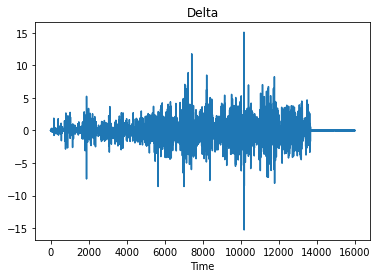

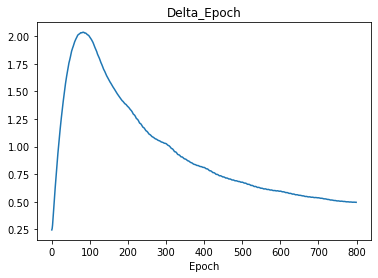

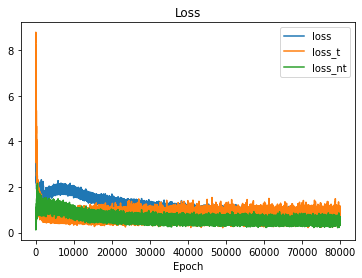

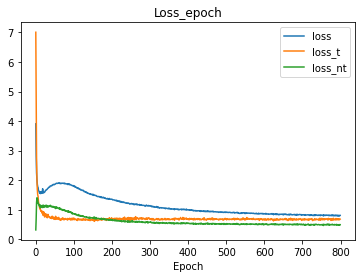

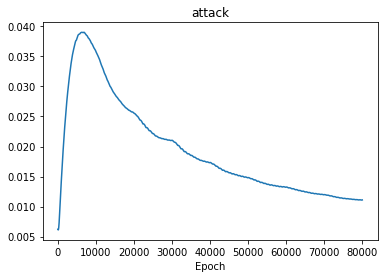

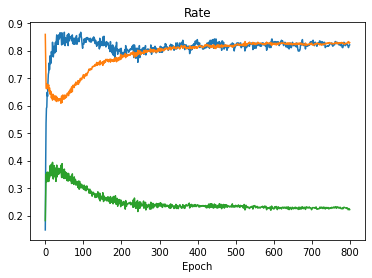

tensor([[-0.0014, -0.0022,  0.0028,  ..., -0.0024,  0.0016, -0.0027]],
       grad_fn=<SqueezeBackward1>)


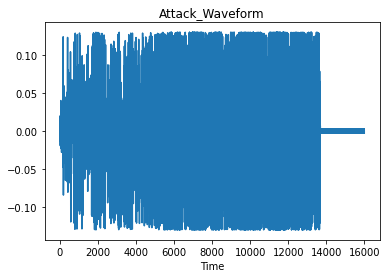

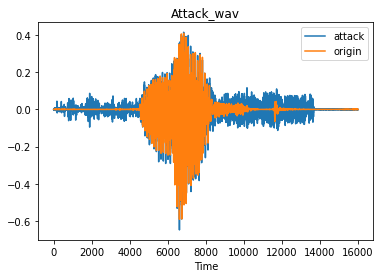


Test Epoch: 0	Attack_Accuracy: 338/412 (82%)


Test Epoch: 0	maintain_Accuracy: 2481/2993 (83%)



In [23]:

time_ = time.strftime('%d_%H_%M_%S',time.localtime(time.time()))
dir_path = os.path.join('output',time_)
os.mkdir(os.path.join('output',time_)) 

print(delta)
plt.plot(delta.squeeze().detach().to('cpu').numpy())
plt.xlabel("Time")
plt.title("Delta")
plt.savefig(os.path.join(dir_path,"Delta.png"), facecolor ="w" , edgecolor = "w") 
plt.show()
plt.close()
plt.plot(delta_sum)
plt.xlabel("Epoch")
plt.title("Delta_Epoch")
plt.savefig(os.path.join(dir_path,"Delta_Epoch.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
plt.plot(losses, label='loss')
plt.plot(losses_t, label='loss_t')
plt.plot(losses_nt, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss")
plt.savefig(os.path.join(dir_path,"Loss.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(losses_epoch, label='loss')
plt.plot(losses_t_epoch, label='loss_t')
plt.plot(losses_nt_epoch, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss_epoch")
plt.savefig(os.path.join(dir_path,"Loss_epoch.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()


plt.plot(delta_wav)
plt.xlabel("Epoch")
plt.title("attack")
plt.savefig(os.path.join(dir_path,"Attack.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
plt.plot(attack_,label='attack')
plt.plot(maintain_,label='maintain')
plt.plot(error_,label='error')
plt.xlabel("Epoch")
plt.title("Rate")
plt.savefig(os.path.join(dir_path,"Rate.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
threshold = 0.2 + (n_epoch // threshold_epoch  -1 ) * 0.07

delta_ = threshold*torch.tanh(delta)
delta_ = delta_.to('cpu')
delta_ = torch.squeeze(delta_,0)

print(delta_)
plt.plot(torch.squeeze(delta_,0).detach().numpy())
plt.xlabel("Time")
plt.title("Attack_Waveform")
plt.savefig(os.path.join(dir_path,"Attack_Waveform.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
torchaudio.save(os.path.join(dir_path,"Attack.wav"), delta_ , sample_rate=16000, channels_first=True)


test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)

f = open(os.path.join(dir_path,"Parameter_2.txt"), "w")  # 打开文件
print("n_epoch=",n_epoch,file=f)
print("threshold_epoch=",threshold_epoch,file=f)
print("target:origin=1:0.5",file=f)

f.close()


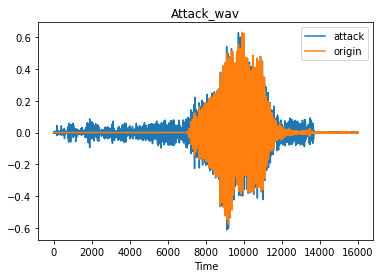


Test Epoch: 0	Attack_Accuracy: 338/412 (82%)


Test Epoch: 0	maintain_Accuracy: 2481/2993 (83%)


Test Epoch: 0	Attack_Accuracy: 0/412 (0%)


Test Epoch: 0	maintain_Accuracy: 2932/2993 (98%)



In [24]:
test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)
test_attack(model,0,threshold_epoch)

In [25]:
output = model(delta)
output = output[0]
print(output)
pred = get_likely_index(output)
print(index_to_label(pred[0]))

tensor([[-2.6220e+01, -2.7878e+01, -1.5127e+01, -1.0988e+01, -3.4038e+01,
         -9.2945e+00, -1.1277e-04, -3.4483e+01, -1.6618e+01, -1.2540e+01]],
       device='cuda:0', grad_fn=<SelectBackward>)
stop


In [26]:
val_set = []
for i in range(len(train_set_)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set_[i]
    
    if label == 'yes':
        val_set.append((waveform, sample_rate, label, speaker_id, utterance_number))

val_test_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [27]:
attack_ = 0
for data, target in val_test_loader:
    #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

    threshold = 0.1
    a_data = data
    data = data.to(device)
    delta_ = threshold*torch.tanh(0.25*delta)
        
    delta_ = delta_.repeat(data.size(0),1,1)
    #data[:,:,random_start:random_start + delta.size(2)] += delta_
    data += delta_
        
    target = target.to(device)
    #print('target',target.size())

    # apply transform and model on whole batch directly on device
        
    data_ = transform(data)
        
    output = model(data_)

    pred = get_likely_index(output)
    pred = pred.squeeze()
    #print(pred.size())
    print(len(target))

    for i in range(len(target)):
        if pred[i] == label_to_index('yes'):
            attack_ += 1
print(attack_/len(val_set))


256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
204
0.7962413452027696


In [28]:
print(len(attack_train_loader))

NameError: name 'attack_train_loader' is not defined

Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


